In [1]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

%matplotlib inline


# ref: Kaggleコード遺産 https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# 再現性確保!
seed_everything(510)

In [2]:
# 学習用のログデータと正解ラベル
train_log_df = pd.read_csv("./input/train_log.csv")
train_label_df = pd.read_csv("./input/train_label.csv")

# 宿のデータ
yado_df = pd.read_csv("./input/yado.csv")

# テスト期間のログデータ
test_log_df = pd.read_csv("./input/test_log.csv")

sample_submission_df = pd.read_csv("./input/sample_submission.csv")

In [3]:
train_log_df.head()

,session_id,seq_no,yad_no
0,000007603d533d30453cc45d0f3d119f,0,2395
1,0000ca043ed437a1472c9d1d154eb49b,0,13535
2,0000d4835cf113316fe447e2f80ba1c8,0,123
3,0000fcda1ae1b2f431e55a7075d1f500,0,8475
4,000104bdffaaad1a1e0a9ebacf585f33,0,96


In [4]:
train_label_df.head()

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96


In [5]:
yado_df.head()

,yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
0,1,0,129.0,1.0,0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,677a32689cd1ad74e867f1fbe43a3e1c
1,2,0,23.0,1.0,0,NaN,NaN,NaN,NaN,d86102dd9c232bade9a97dccad40df48,b4d2fb4e51ea7bca80eb1270aa474a54,5c9a8f48e9df0234da012747a02d4b29,4ee16ee838dd2703cc9a1d5a535f0ced
2,3,0,167.0,1.0,1,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c
3,4,0,144.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52c9ea83f2cfe92be54cb6bc961edf21,1cc3e1838bb0fd0fde0396130b1f82b9
4,5,0,41.0,1.0,1,NaN,NaN,NaN,NaN,43875109d1dab93592812c50d18270a7,75617bb07a2785a948ab1958909211f1,9ea5a911019b66ccd42f556c42a2fe2f,be1b876af18afc4deeb3081591d2a910


In [6]:
test_log_df.head()

,session_id,seq_no,yad_no
0,00001149e9c73985425197104712478c,0,3560
1,00001149e9c73985425197104712478c,1,1959
2,0000e02747d749a52b7736dfa751e258,0,11984
3,0000f17ae2628237d78d3a38b009d3be,0,757
4,0000f17ae2628237d78d3a38b009d3be,1,8922


In [7]:
sample_submission_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,12217,5055,4744,3410,11442,3711,8190,9998,13023,9297
1,12340,13720,1378,681,2020,11125,10129,4159,8184,7966
2,196,8757,6241,7376,13608,1693,13745,8065,13022,303
3,6448,3482,5687,2335,911,9008,8209,595,8171,10040
4,6327,1606,12898,3785,8212,910,10430,4260,9767,383


In [8]:
# すべてのログデータ
whole_log_df = pd.concat([train_log_df, test_log_df], ignore_index=True)

In [9]:
def create_session_yad_df(input_df: pd.DataFrame):
    """input_df には train_log / test_log のいずれかが来ることを想定している"""

    N = 10
    sessions = input_df["session_id"].unique()
    out_df = pd.DataFrame({
        "session_id": [x for s in sessions for x in [s] * N],
        "yad_no": yado_df["yad_no"].sample(n=N * len(sessions), replace=True).values
    })

    # ランダムに付け加えたもの以外・同一ログに出現する宿を候補にいれる
    out_df = pd.concat([out_df, input_df[["session_id", "yad_no"]]], ignore_index=True)

    # 重複は意味がないので消します。
    out_df = out_df.drop_duplicates()

    # 見た目を揃えるために session / yad の順番でソートをします
    out_df = out_df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

    return out_df

In [10]:
train_session_yad_df = create_session_yad_df(input_df=train_log_df)

# 予測の際には session ごとに yado に対しての予約確率を出さなくてはなりませんから、同じように session - yado の組を作ります。
# ただし学習時と同じような組で良いか? は議論が必要かもしれません. (ここに現れない宿は予測対象に絶対入らないため)
test_session_yad_df = create_session_yad_df(input_df=test_log_df)

In [11]:
train_session_yad_df.head(20)

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,2395
1,000007603d533d30453cc45d0f3d119f,3410
2,000007603d533d30453cc45d0f3d119f,3711
3,000007603d533d30453cc45d0f3d119f,4744
4,000007603d533d30453cc45d0f3d119f,5055
5,000007603d533d30453cc45d0f3d119f,8190
6,000007603d533d30453cc45d0f3d119f,9297
7,000007603d533d30453cc45d0f3d119f,9998
8,000007603d533d30453cc45d0f3d119f,11442
9,000007603d533d30453cc45d0f3d119f,12217


In [12]:
# 正解ラベル train_label_df の組み合わせを付与
_df = pd.concat([train_label_df, train_session_yad_df], ignore_index=True)

# 重複を削除して
_df = _df.drop_duplicates().reset_index(drop=True)

# 正解ラベルに含まれているレコードの index を配列で取得して
target_index = pd.merge(_df.reset_index(), train_label_df, on=["session_id", "yad_no"], how="inner")["index"].values

# 正解Indexに含まれている場合 1 / そうでないと 0 のラベルを作成
_df["target"] = _df.index.isin(target_index).astype(int)

# 見た目を揃えるために session / yad でソートしておく
_df = _df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

_df.head(20)

,session_id,yad_no,target
0,000007603d533d30453cc45d0f3d119f,2395,0
1,000007603d533d30453cc45d0f3d119f,3410,0
2,000007603d533d30453cc45d0f3d119f,3711,0
3,000007603d533d30453cc45d0f3d119f,4101,1
4,000007603d533d30453cc45d0f3d119f,4744,0
5,000007603d533d30453cc45d0f3d119f,5055,0
6,000007603d533d30453cc45d0f3d119f,8190,0
7,000007603d533d30453cc45d0f3d119f,9297,0
8,000007603d533d30453cc45d0f3d119f,9998,0
9,000007603d533d30453cc45d0f3d119f,11442,0


In [13]:
train_session_yad_df = _df.copy()

<Axes: xlabel='yad_no'>

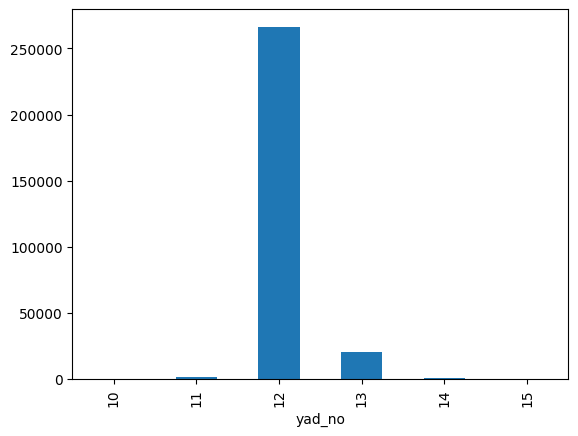

In [14]:
train_session_yad_df.groupby("session_id")["yad_no"].nunique().value_counts().sort_index().plot(kind="bar")

In [15]:
def remove_last_yad_id(session_yad_df):

    # セッション中一番最後の宿の組を作成
    last_yad_df = whole_log_df.groupby("session_id").tail(1)[["session_id", "yad_no"]]

    # 最後であることがわかるようにラベル is_last を付与
    last_yad_df["is_last"] = 1

    # 引数の session - yad の組み合わせとマージして
    merged = session_yad_df.merge(last_yad_df, on=["session_id", "yad_no"], how="left")

    # is_last **ではない** (i.e. is_last is null) データのみに絞る
    idx_use = merged["is_last"].isnull()
    out_df = session_yad_df[idx_use].reset_index(drop=True)

    return out_df

test_session_yad_df = remove_last_yad_id(test_session_yad_df)

<Axes: xlabel='yad_no'>

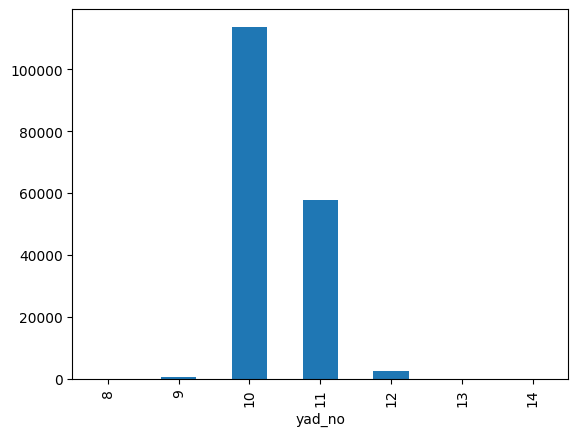

In [16]:
test_session_yad_df.groupby("session_id")["yad_no"].nunique().value_counts().sort_index().plot(kind="bar")

In [17]:
session_length = whole_log_df.groupby("session_id")["seq_no"].max()
session_length.head()

session_id
000007603d533d30453cc45d0f3d119f    0
00001149e9c73985425197104712478c    1
0000ca043ed437a1472c9d1d154eb49b    0
0000d4835cf113316fe447e2f80ba1c8    0
0000e02747d749a52b7736dfa751e258    0
Name: seq_no, dtype: int64

In [18]:
def create_session_length_feature(input_df: pd.DataFrame):
    session_length = whole_log_df.groupby("session_id")["seq_no"].max().rename("session_length")

    out_df = pd.merge(input_df["session_id"], session_length, on="session_id", how="left").drop(columns=["session_id"])
    return out_df

In [19]:
create_session_length_feature(train_session_yad_df)

,session_length
0,0
1,0
2,0
3,0
4,0
...,...
3484679,1
3484680,1
3484681,1
3484682,1


In [20]:
yado_df.dtypes

yad_no                 int64
yad_type               int64
total_room_cnt       float64
wireless_lan_flg     float64
onsen_flg              int64
kd_stn_5min          float64
kd_bch_5min          float64
kd_slp_5min          float64
kd_conv_walk_5min    float64
wid_cd                object
ken_cd                object
lrg_cd                object
sml_cd                object
dtype: object

In [21]:
def create_yado_numaric_feature(input_df: pd.DataFrame):
    num_columns = [
        'yad_type',
        'total_room_cnt',
        'wireless_lan_flg',
        'onsen_flg',
        'kd_stn_5min',
        'kd_bch_5min',
        'kd_slp_5min',
        'kd_conv_walk_5min',
    ]

    # key となる `yad_no` を付与するのをお忘れなく.
    out_df = pd.merge(input_df["yad_no"], yado_df[["yad_no", *num_columns]], how="left").drop(columns=["yad_no"])
    return out_df

In [22]:
create_yado_numaric_feature(train_session_yad_df)

,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min
0,0,113.0,1.0,0,NaN,NaN,NaN,NaN
1,0,149.0,NaN,0,NaN,NaN,NaN,1.0
2,0,35.0,NaN,1,NaN,NaN,NaN,NaN
3,0,39.0,NaN,0,NaN,NaN,NaN,1.0
4,0,110.0,1.0,0,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
3484679,0,61.0,NaN,1,NaN,NaN,NaN,1.0
3484680,0,126.0,1.0,0,1.0,NaN,NaN,1.0
3484681,0,161.0,1.0,0,1.0,NaN,NaN,1.0
3484682,0,56.0,1.0,0,NaN,NaN,NaN,NaN


In [23]:
# LabelEncoding は scikit-learn に変換ロジックが用意されていますのでそれを利用するのが便利です。
from sklearn.preprocessing import LabelEncoder

# 使い方はシンプルで, LabelEncoder を定義したあと fit_trainsform で与えられた配列を数値 Label に変換します。
le = LabelEncoder()

wid_cd_label = le.fit_transform(yado_df["wid_cd"])
wid_cd_label

array([11,  8,  3, ...,  8,  1, 11])

In [24]:
def create_yad_wid_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame({
        "yad_no": yado_df["yad_no"],
        "wid_cd_label": wid_cd_label
    })

    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(columns=["yad_no"])
    return out_df

In [25]:
create_yad_wid_cd_feature(train_session_yad_df)

,wid_cd_label
0,9
1,2
2,7
3,9
4,9
...,...
3484679,9
3484680,0
3484681,3
3484682,8


In [26]:
# いままでの関数をすべてがっちゃんこして特徴量を作成する関数を定義しましょう!

def create_feature(input_df):

    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_session_length_feature,
        create_yado_numaric_feature,
        create_yad_wid_cd_feature,
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"- create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [27]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df = create_feature(train_session_yad_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_session_yad_df)

X = train_feat_df.values
y = train_session_yad_df["target"].values

- create create_session_length_feature 1.657[s]
- create create_yado_numaric_feature 0.927[s]
- create create_yad_wid_cd_feature 0.460[s]
train... 3.397[s]
- create create_session_length_feature 1.286[s]
- create create_yado_numaric_feature 0.519[s]
- create create_yad_wid_cd_feature 0.271[s]
test... 2.160[s]


In [28]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=5)
cv = fold.split(X, y, groups=train_session_yad_df["session_id"].values)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく

In [29]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, \
    r2_score, mean_squared_log_error, median_absolute_error, explained_variance_score, cohen_kappa_score, \
    average_precision_score, precision_score, recall_score


def binary_metrics(y_true: np.ndarray,
                   predict_probability: np.ndarray,
                   threshold=.5) -> dict:
    """
    calculate binary task metrics
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    none_prob_functions = [
        accuracy_score,
        f1_score,
        precision_score,
        recall_score
    ]

    prob_functions = [
        roc_auc_score,
        log_loss,
        average_precision_score
    ]

    scores = {}
    for f in none_prob_functions:
        score = f(y_true, predict_label)
        scores[str(f.__name__)] = score
    for f in prob_functions:
        score = f(y_true, predict_probability)
        scores[f.__name__] = score

    return scores

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        print(f"-- start fold {i}")
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params, verbose=0)

        with Timer(prefix="fit fold={} ".format(i)):

            # cv 内で train に定義された x_train で学習する
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    callbacks=[
                        lgbm.early_stopping(stopping_rounds=100, verbose=False),
                        lgbm.log_evaluation(period=100, ),
                    ],)

        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = binary_metrics(y_valid, pred_i)
        print(f" - fold{i + 1} - {score}")

    score = binary_metrics(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score}")
    return oof_pred, models

In [30]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "binary", 

    # 木の最大数
    "n_estimators": 10000, 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": .2,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 510,
}

oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

-- start fold 0
[100]	valid_0's binary_logloss: 0.259634
[200]	valid_0's binary_logloss: 0.25817
[300]	valid_0's binary_logloss: 0.25727
[400]	valid_0's binary_logloss: 0.256528
[500]	valid_0's binary_logloss: 0.256056
[600]	valid_0's binary_logloss: 0.255654
[700]	valid_0's binary_logloss: 0.25534
[800]	valid_0's binary_logloss: 0.25506
[900]	valid_0's binary_logloss: 0.254856
[1000]	valid_0's binary_logloss: 0.254732
[1100]	valid_0's binary_logloss: 0.254618
[1200]	valid_0's binary_logloss: 0.254517
[1300]	valid_0's binary_logloss: 0.254401
[1400]	valid_0's binary_logloss: 0.254338
[1500]	valid_0's binary_logloss: 0.254243
[1600]	valid_0's binary_logloss: 0.254195
[1700]	valid_0's binary_logloss: 0.254157
[1800]	valid_0's binary_logloss: 0.254158
fit fold=0  94.545[s]
 - fold1 - {'accuracy_score': 0.9170790640814646, 'f1_score': 0.0019687419048441414, 'precision_score': 0.34545454545454546, 'recall_score': 0.0009871839279528922, 'roc_auc_score': 0.750415502939379, 'log_loss': 0.25414

In [31]:
def create_top_10_yad_predict(predict, session_yad_df):
    _df = pd.concat([session_yad_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")], axis=1)

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = _df.sort_values("predict", ascending=False).groupby("session_id")["yad_no"].apply(list)

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]

    return out_df

In [32]:
oof_label_df = create_top_10_yad_predict(predict=oof, session_yad_df=train_session_yad_df)
oof_label_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,4744,9297,11442,5055,12217,3410,13023,9998,2395,4101
0000ca043ed437a1472c9d1d154eb49b,11125,12340,13535,8253,2020,681,7966,4159,8184,10129
0000d4835cf113316fe447e2f80ba1c8,13608,8757,8065,13745,13022,196,303,1693,4863,7376
0000fcda1ae1b2f431e55a7075d1f500,1652,8475,5687,2335,10040,6448,3482,595,911,8171
000104bdffaaad1a1e0a9ebacf585f33,898,96,910,10430,6327,3785,1606,9767,4260,383
...,...,...,...,...,...,...,...,...,...,...
ffff2262d38abdeb247ebd591835dcc9,8140,2259,878,8757,8454,276,13499,1106,7329,1086
ffff2360540745117193ecadcdc06538,11780,3764,50,963,2121,5236,2907,11452,3594,4462
ffff7fb4617164b2604aaf51c40bf82d,13292,13719,7183,6343,1858,4664,5225,2565,4708,7208


In [33]:
def apk(actual, predicted, k=10):
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0

def mapk(actual, predicted, k=10):
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [34]:
# いま作成した session_id と同じ並びで train_label を並び替え
train_label = train_label_df.set_index("session_id").loc[oof_label_df.index]["yad_no"].values

In [35]:
# MAPK (k=10) として計算
mapk(actual=train_label, predicted=oof_label_df.values.tolist(), k=10)

0.4445492087239937

/var/folders/fl/4c0rpb892c562skg_5y1ghl00000gn/T/ipykernel_25778/1168668338.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


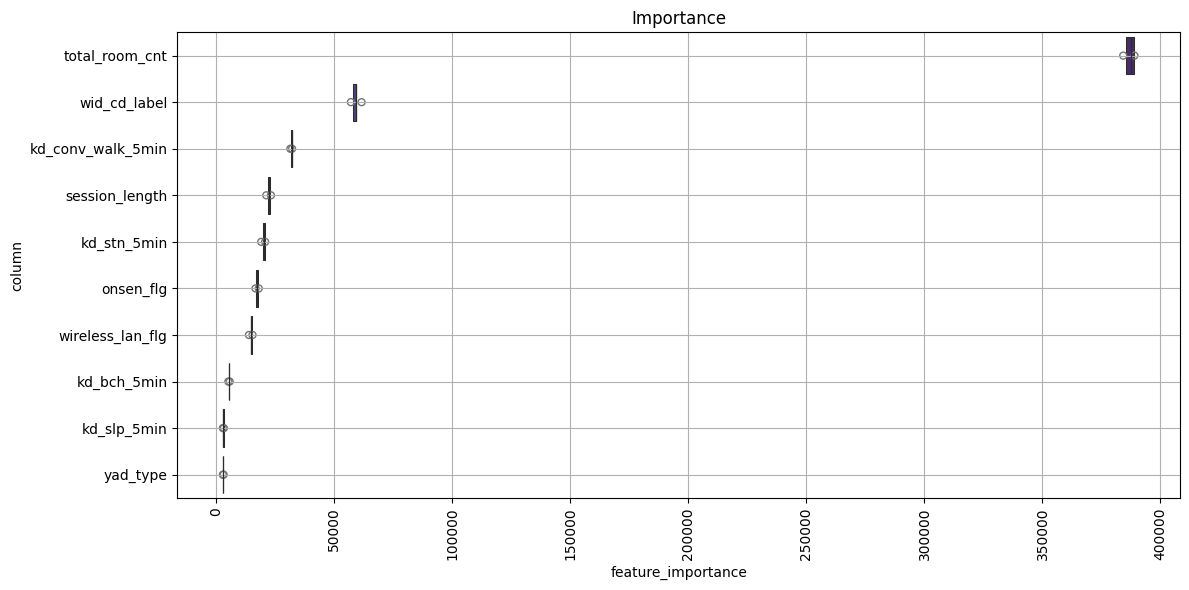

In [36]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

(-10.0, 510.0)

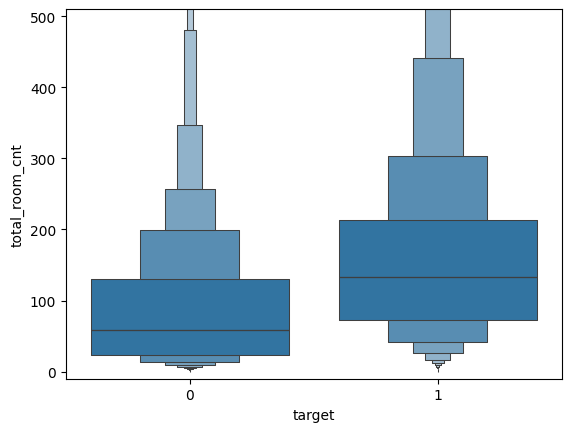

In [37]:
ax = sns.boxenplot(data=pd.DataFrame({
    "total_room_cnt": train_feat_df["total_room_cnt"],
    "target": y
}), x="target", y="total_room_cnt")

ax.set_ylim([-10, 510])

In [38]:
# k 個のモデルの予測確率 (predict_proba) を作成. shape = (5, N_test,).
pred_prob = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])

In [39]:
# k 個のモデルの予測値の平均 shape = (N_test,).
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる 

<Axes: ylabel='Count'>

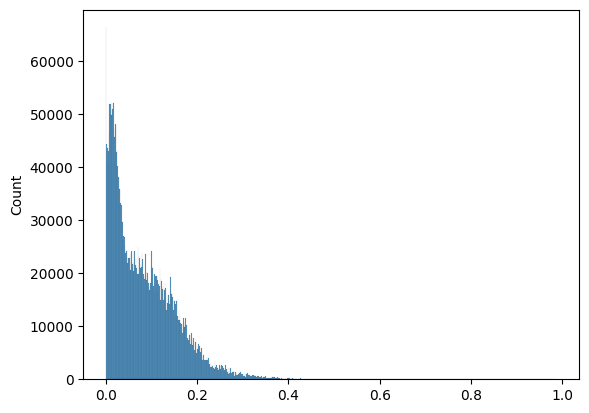

In [40]:
sns.histplot(oof)

<Axes: ylabel='Count'>

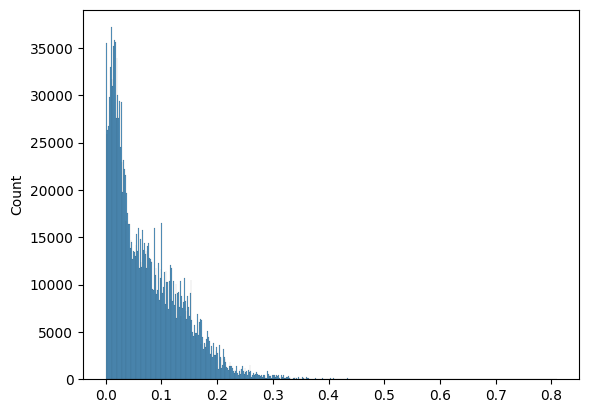

In [41]:
sns.histplot(pred_prob)

In [43]:
test_pred_df = create_top_10_yad_predict(predict=pred_prob, session_yad_df=test_session_yad_df)
test_pred_df.iloc[:, :10].fillna(0).astype(int).add_prefix("predict_").to_csv("./output/#1_submission.csv", index=False)

In [44]:
test_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
00001149e9c73985425197104712478c,5106,8665,3560,3275,3572,9778,5404,5373,9249.0,7464.0
0000e02747d749a52b7736dfa751e258,3575,7775,7600,3682,549,3317,12984,2892,8428.0,4212.0
0000f17ae2628237d78d3a38b009d3be,7154,1750,12388,10771,757,2292,9557,12283,617.0,12820.0
000174a6f7a569b84c5575760d2e9664,1264,12341,8491,9603,1219,10762,8948,6325,8317.0,12883.0
00017e2a527901c9c41b1acef525d016,10449,2421,13634,12869,8520,4108,5643,8212,3206.0,2405.0
